# Anomaly Detection

Demo Notebooks SAM and Grounded DINO
- https://github.com/xinyu1205/recognize-anything/blob/main/recognize_anything_demo.ipynb
- https://github.com/xinyu1205/recognize-anything/blob/main/gui_demo.ipynb

In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from mae import mae_vit_base_patch16, mae_vit_large_patch16, mae_vit_huge_patch14
from mae_utils import (
    load_mae,
    process_image,
    show_image,
    visualize_images,
    imagenet_mean,
    imagenet_std,
)

from functools import partial

from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from timm.models.vision_transformer import PatchEmbed, Block
from PIL import Image, ImageDraw, ImageFont

from ram_gdino import (
    extract_objects_from_bounding_boxes,
    detect_objects_with_ram,
    # get_grounding_output,
    # inference,
    load_ram,
    load_tag2text,
    load_grounding_dino,
    draw_box
    # load_sam
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Recognize Anything

In [2]:
%%capture
# usually takes around 1min on RTX 3090
ram_model = load_ram(device)
tag2text_model = load_tag2text(device)
grounding_dino_model = load_grounding_dino(device)

ram_model = ram_model.to(device)
tag2text_model = tag2text_model.to(device)
grounding_dino_model = grounding_dino_model.to(device)
# sam_model = load_sam(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


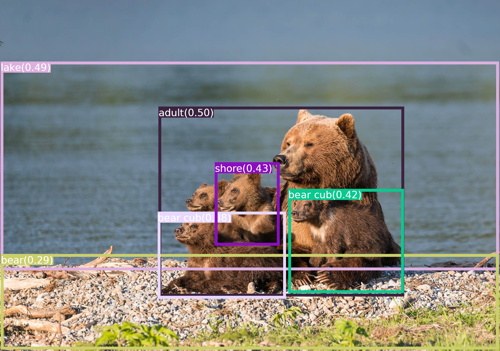

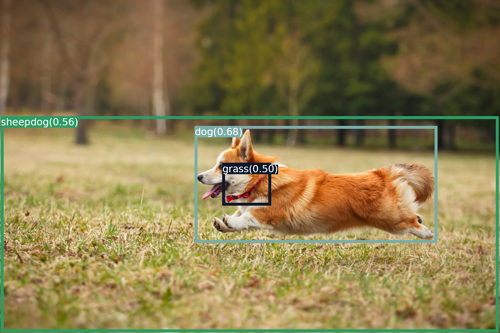

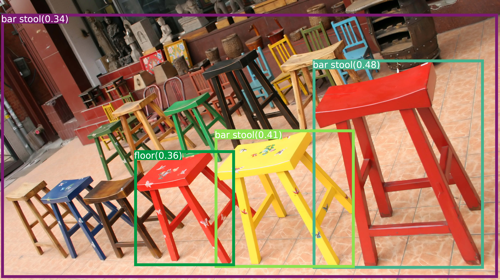

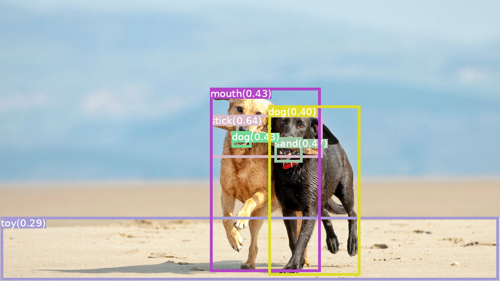

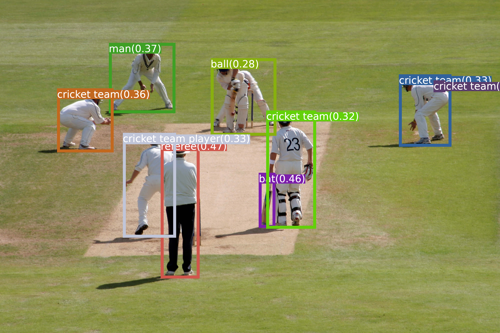

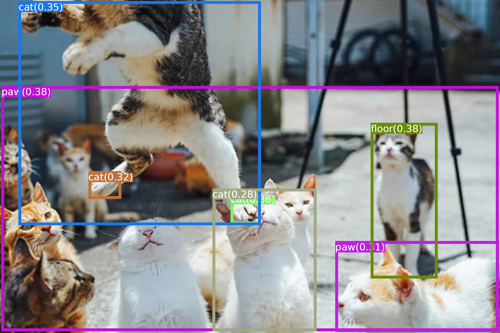

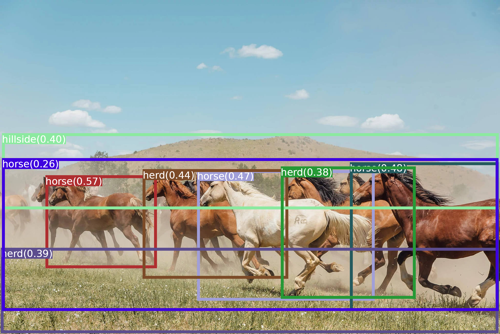

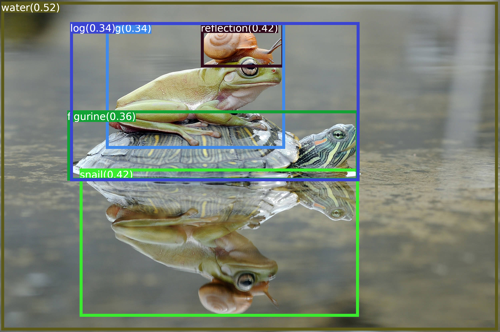

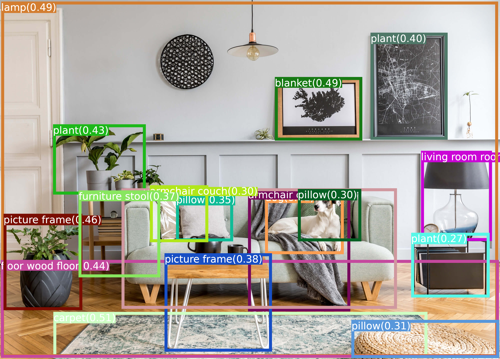

CPU times: user 2.95 s, sys: 61.9 ms, total: 3.01 s
Wall time: 2.98 s


In [13]:
%%time
objects_pool = []
objects_pool_path = "objects_pool/all_images"
if not os.path.exists(objects_pool_path):
    os.mkdir(objects_pool_path)

n = 10
for i in range(1, 10):
    # Open Image
    in_img = Image.open(f"Grounded-Segment-Anything/assets/demo{i}.jpg")
    # print("-----\n")

    # Return tags, bounding boxes, and labels
    ram_out_image, boxes_filt = detect_objects_with_ram(
        in_img, grounding_dino_model, ram_model, draw_boxes=True, device=device
    )

    # Display image
    ram_out_image.thumbnail((500, 500))
    display(ram_out_image.convert("RGB"))

    # Get object images from using bounding boxes
    current_object_images = extract_objects_from_bounding_boxes(in_img, boxes_filt)

    # Save images to list
    # objects_pool.extend([(obj, phrase[0]) for obj, phrase in zip(current_object_images, pred_phrases)])

    # Save object images to folder
    # for idx, obj_image in enumerate(current_object_images, start=1):
    #     save_path = os.path.join(objects_pool_path, f"demo{i}_object{idx}.jpg")
    #     obj_image.convert("RGB").save(save_path)

## Masked AutoEncoder (Scalable Vision Learners)

Demo notebook: https://colab.research.google.com/github/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb

In [6]:
# # Data transformations (you can adjust as needed)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# # Load dataset
# dataset = datasets.ImageFolder(root='objects_pool/', transform=transform)

# # Split dataset into train and validation (you can adjust split ratio)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [47]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, _ in dataloader:  # we don't need labels
        imgs = imgs.to(device)

        # Forward pass
        loss, _, _ = model(imgs)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(dataloader.dataset)

def validate_epoch(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            loss, _, _ = model(imgs)
            running_loss += loss.item() * imgs.size(0)
    return running_loss / len(dataloader.dataset)

In [8]:
# # Initialize model, criterion and optimizer
# model = mae_vit_large_patch16().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 20
# for epoch in range(num_epochs):
#     train_loss = train_epoch(model, train_loader, None, optimizer, device)  # criterion is not passed as it's internal to the model
#     val_loss = validate_epoch(model, val_loader, device)
#     print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# # Save the trained model
# torch.save(model.state_dict(), "masked_autoencoder_vit.pth")

Epoch [1/20] | Train Loss: 0.7964 | Val Loss: 0.1703
Epoch [2/20] | Train Loss: 0.1284 | Val Loss: 0.0729
Epoch [3/20] | Train Loss: 0.0738 | Val Loss: 0.0746
Epoch [4/20] | Train Loss: 0.0790 | Val Loss: 0.0817
Epoch [5/20] | Train Loss: 0.0889 | Val Loss: 0.0904
Epoch [6/20] | Train Loss: 0.0948 | Val Loss: 0.0862
Epoch [7/20] | Train Loss: 0.0879 | Val Loss: 0.0768
Epoch [8/20] | Train Loss: 0.0796 | Val Loss: 0.0721
Epoch [9/20] | Train Loss: 0.0745 | Val Loss: 0.0696
Epoch [10/20] | Train Loss: 0.0709 | Val Loss: 0.0671
Epoch [11/20] | Train Loss: 0.0684 | Val Loss: 0.0655
Epoch [12/20] | Train Loss: 0.0690 | Val Loss: 0.0647
Epoch [13/20] | Train Loss: 0.0676 | Val Loss: 0.0625
Epoch [14/20] | Train Loss: 0.0662 | Val Loss: 0.0618
Epoch [15/20] | Train Loss: 0.0647 | Val Loss: 0.0588
Epoch [16/20] | Train Loss: 0.0619 | Val Loss: 0.0586
Epoch [17/20] | Train Loss: 0.0620 | Val Loss: 0.0601
Epoch [18/20] | Train Loss: 0.0631 | Val Loss: 0.0596
Epoch [19/20] | Train Loss: 0.0638 | 

### Let's run the MAE flow

In [18]:
# load an image
img = Image.open(f"Grounded-Segment-Anything/assets/demo8.jpg")
img = img.resize((224, 224))
img = np.array(img) / 255.0
img = torch.Tensor(img)

print(img.shape)

# assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

# plt.rcParams["figure.figsize"] = [5, 5]
# show_image(torch.tensor(img))

torch.Size([224, 224, 3])


In [19]:
chkpt_dir = "./pretrained/mae_visualize_vit_large.pth"
model_mae = load_mae(chkpt_dir, arch=mae_vit_large_patch16, device=device)

<All keys matched successfully>


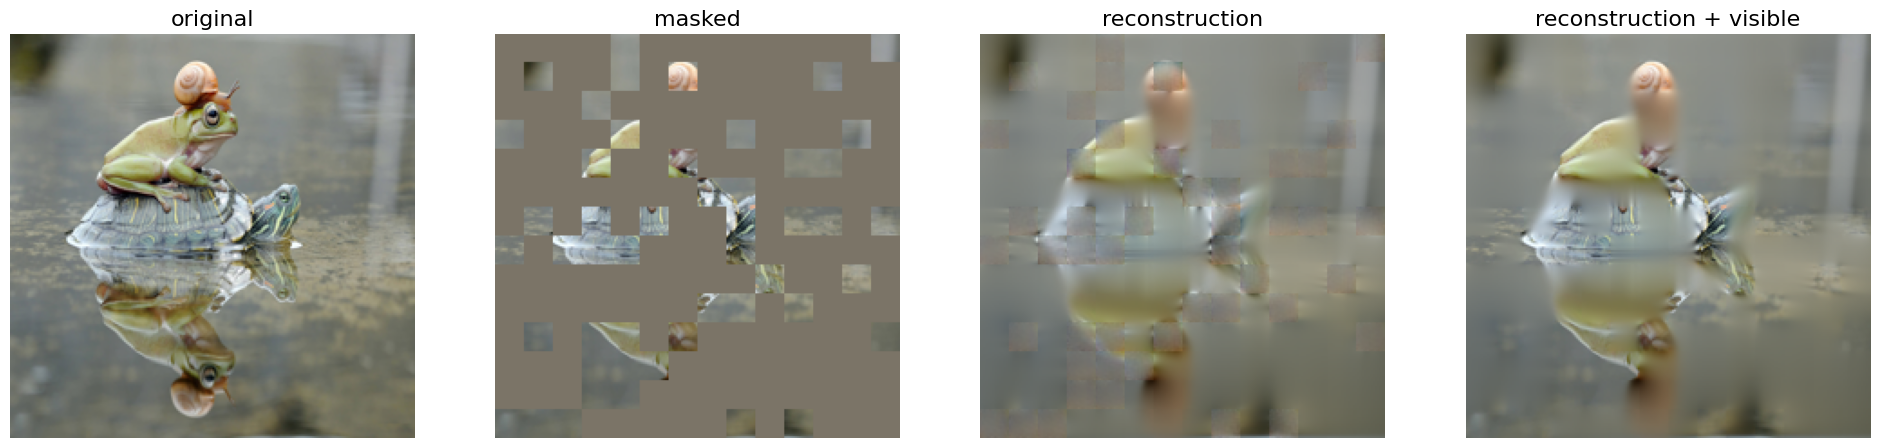

CPU times: user 327 ms, sys: 77.5 ms, total: 404 ms
Wall time: 247 ms


In [20]:
%%time
original, masked, reconstruction, reconstructed_visible = process_image(
    img, model_mae, device=device
)
visualize_images(original, masked, reconstruction, reconstructed_visible)

### Let's say we want to validate multiple images

In [6]:
chkpt_dir = "./pretrained/mae_visualize_vit_large.pth"
model_mae = load_mae(chkpt_dir, arch=mae_vit_large_patch16, device=device)

<All keys matched successfully>


In [7]:
# # Data transformations (you can adjust as needed)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((16, 16)),
#     transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
# ])

# # Load dataset
# dataset = datasets.ImageFolder(root='objects_pool/', transform=transform)

# # Split dataset into train and validation (you can adjust split ratio)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [21]:
# num_epochs = 50
# for epoch in range(num_epochs):
#     train_loss = train_epoch(model_mae, train_loader, None, optimizer, device)  # criterion is not passed as it's internal to the model
#     val_loss = validate_epoch(model_mae, val_loader, device)
#     print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
#     # scheduler.step()

In [7]:
# def validate_epoch(model, dataloader, device):
#     model.eval()
#     running_loss = 0.0
#     with torch.no_grad():
#         for imgs, _ in dataloader:
#             imgs = imgs.to(device)
#             loss, _, _ = model(imgs)
#             running_loss += loss.item() * imgs.size(0)
#     return running_loss / len(dataloader.dataset)

------
Image: 1 | Loss: 0.14486806094646454


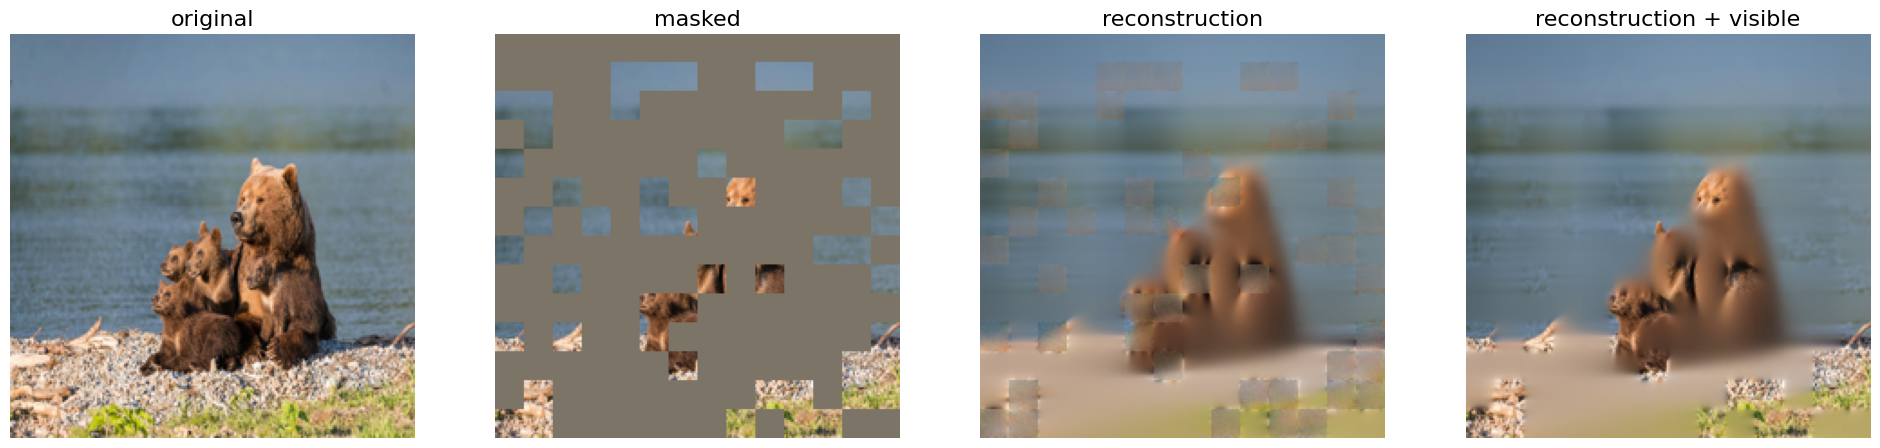

------
Image: 2 | Loss: 0.12039506435394287


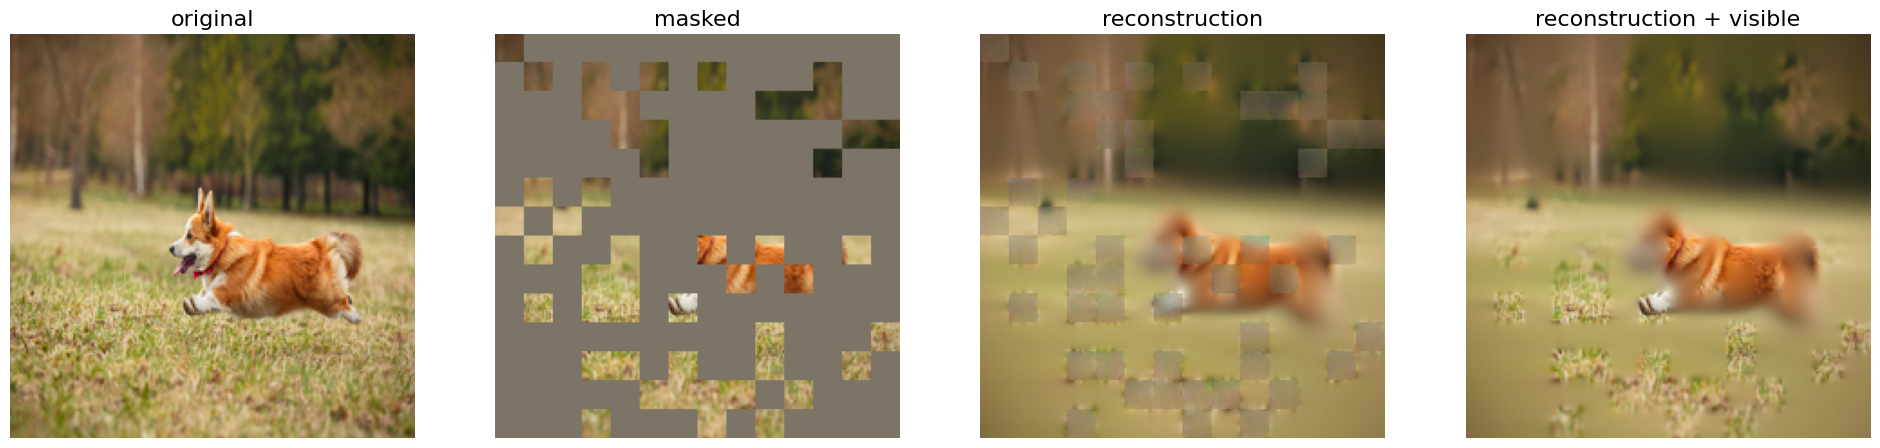

------
Image: 3 | Loss: 0.2879050672054291


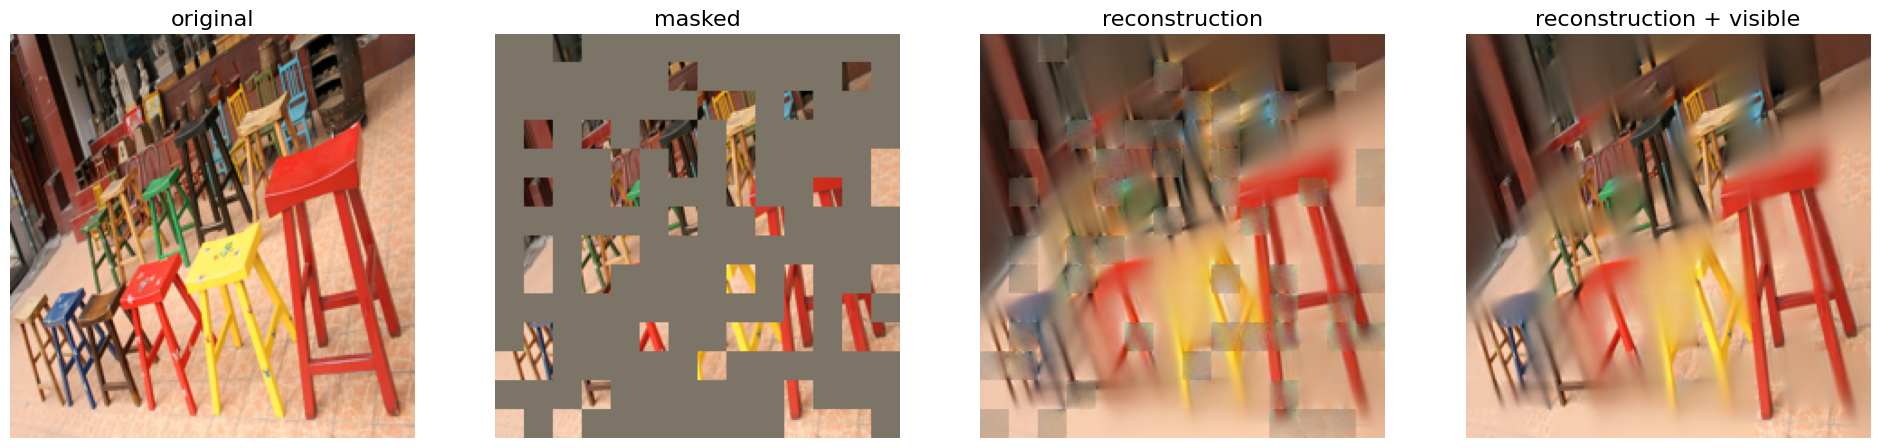

------
Image: 4 | Loss: 0.15174801647663116


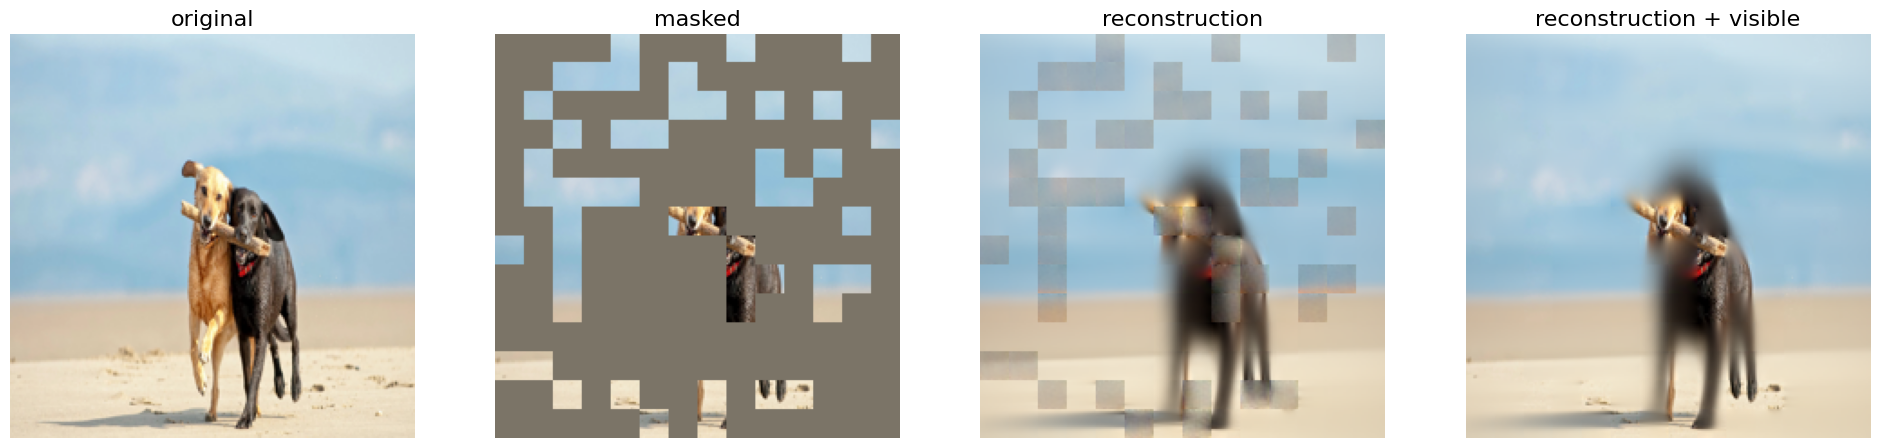

------
Image: 5 | Loss: 0.07150518149137497


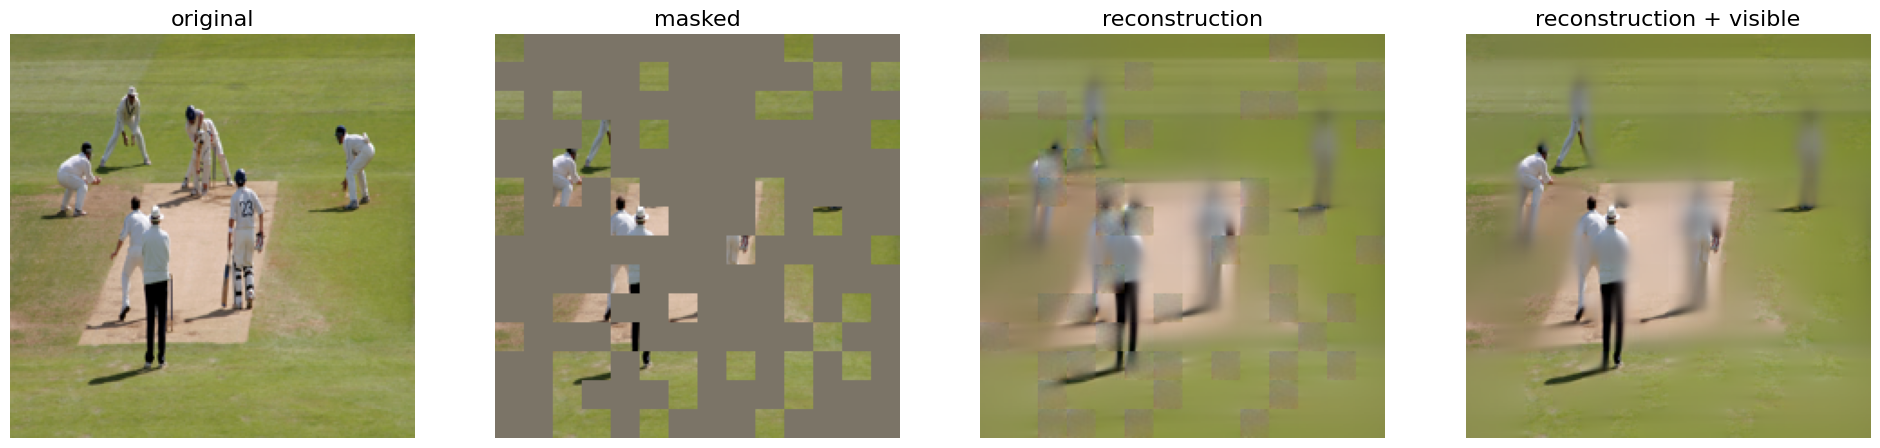

------
Image: 6 | Loss: 0.2759852111339569


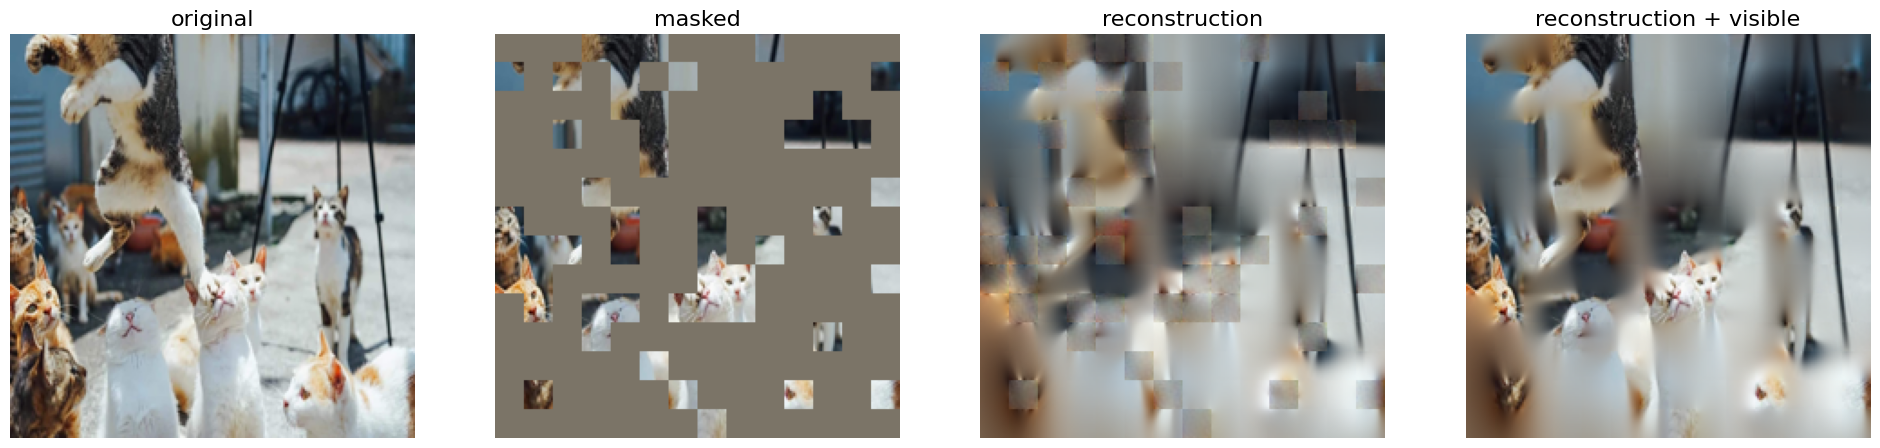

------
Image: 7 | Loss: 0.13869553804397583


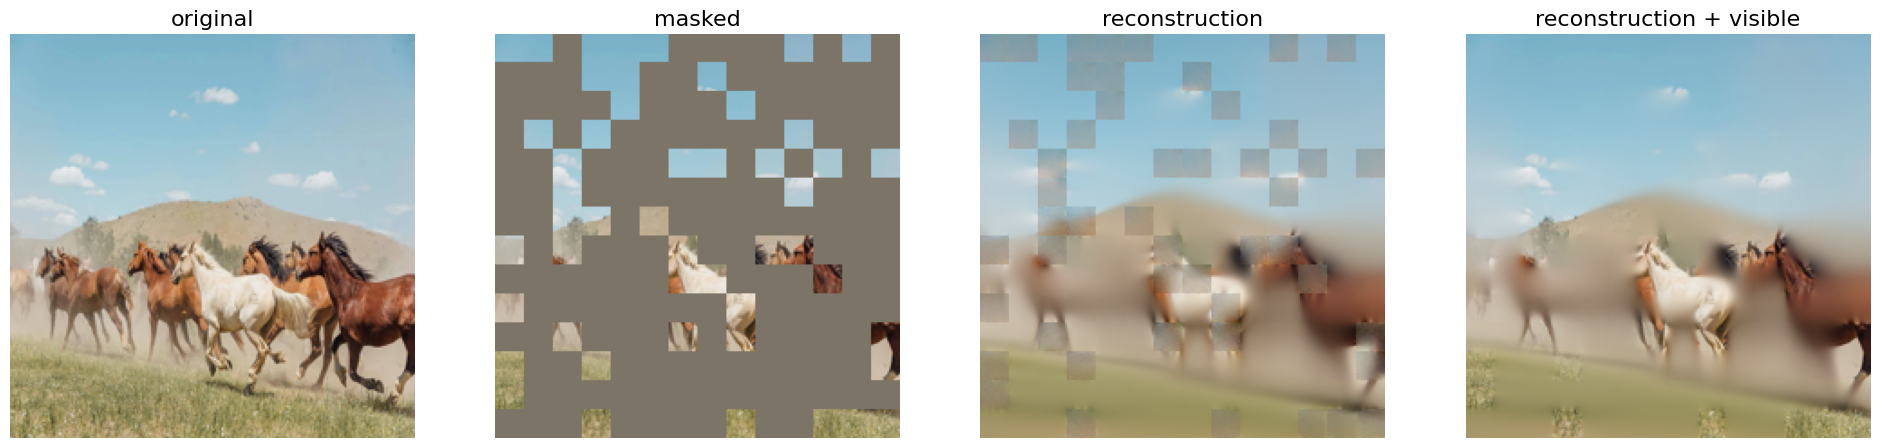

------
Image: 8 | Loss: 0.0860387459397316


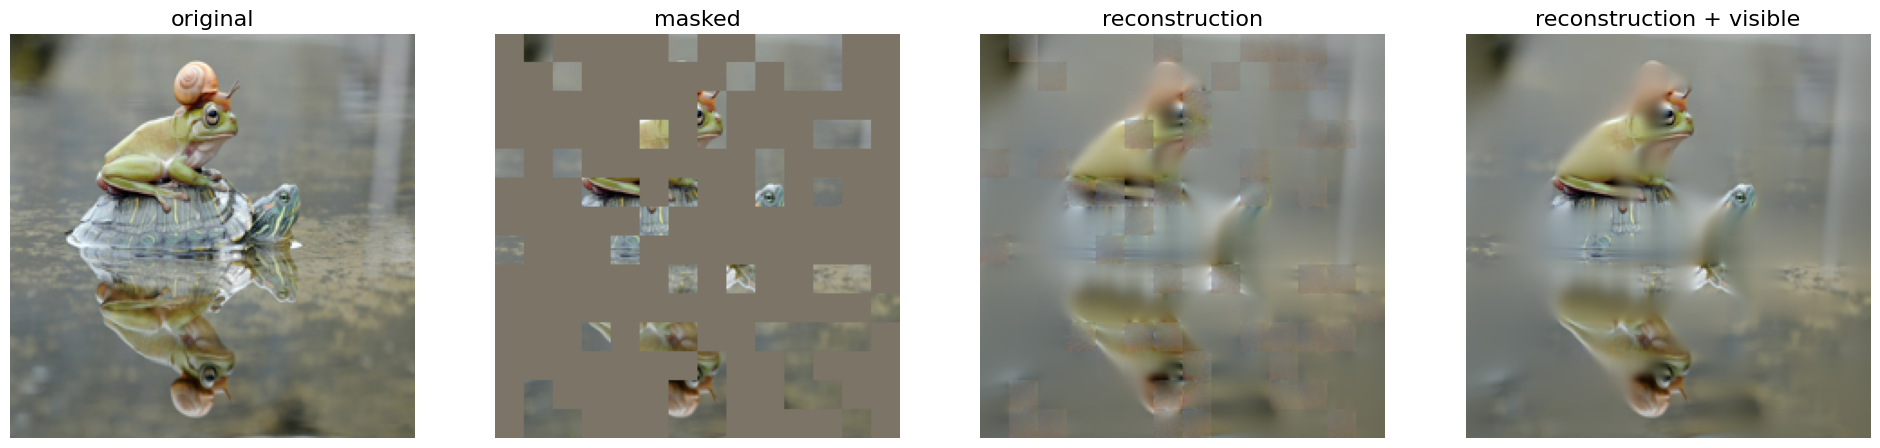

CPU times: user 3.31 s, sys: 680 ms, total: 3.99 s
Wall time: 2.74 s


In [22]:
%%time
for i in range (1, 9):
    # load an image
    img = Image.open(f"Grounded-Segment-Anything/assets/demo{i}.jpg")
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = torch.Tensor(img)
    
    # try:
    print("------")
    # normalize by ImageNet mean and std
    img = img - imagenet_mean
    img = img / imagenet_std

    original, masked, reconstruction, reconstructed_visible = process_image(
        img, model_mae, device=device
    )

    # Compute MSE loss
    mse_loss = F.mse_loss(original, reconstructed_visible)
    print(f"Image: {i} | Loss: {mse_loss.item()}")
    
    visualize_images(original, masked, reconstruction, reconstructed_visible)
    # except:
        # pass

In [71]:
# Data transformations (you can adjust as needed)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# Load dataset
dataset = datasets.ImageFolder(root='objects_pool/', transform=transform)

# Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [72]:
model_mae.eval()
running_loss = 0.0
with torch.no_grad():
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        loss, _, _ = model_mae(imgs)
        running_loss += loss.item() * imgs.size(0)

print(running_loss / len(dataloader.dataset))

0.24139882157098003
